In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
import pathlib


In [2]:
# NYTimes US county level COVID-19 data 
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2Fnytimes%2Fcovid-19-data%2Fmaster%2Fus-counties.csv&filename=us-counties.csv"


In [3]:
### check if we need to download a new file for today, based on the date
location = ''

### filename is covid19data_YYYYMMDD.csv
todayYYYYMMDD = datetime.datetime.today().strftime("%Y%m%d")
cur_filename = location + "covid19data_us-counties_" + todayYYYYMMDD + ".csv"
print(f"looking for today's file: {cur_filename}")


looking for today's file: covid19data_us-counties_20200517.csv


In [4]:
### check if we have today's data file
#print(pathlib.Path().absolute())
cur_file = pathlib.Path(cur_filename)

todays_file_exists = cur_file.exists()
#print(todays_file_exists)

In [5]:
## if today's file does not exist, download data and create it
if not todays_file_exists:
    datafile = requests.get(url)
    with open(cur_filename, 'wb') as f:
        f.write(datafile.content)
    print(f"downloaded data for today to file {cur_filename}")

print(f"using data from file {cur_filename}")

using data from file covid19data_us-counties_20200517.csv


In [6]:
### read the data into a pandas dataframe
df = pd.read_csv(cur_filename, usecols=lambda x: x.lower() not in ('fips'))

In [7]:
### pivot the data in the dataframe to be more easily graphed
tx = df[df['state'] == 'Texas']
txdfw = tx[tx['county'] == 'Dallas']

df_txdfw_pivot = txdfw.pivot(index='date', columns='county', values=['cases', 'deaths'])

In [8]:
### capture additional data
#latest_day_str = df_txdfw_pivot.index.max()
latest_day_dt = datetime.datetime.strptime(df_txdfw_pivot.index.max(), "%Y-%m-%d")
print(type(latest_day_dt))

<class 'datetime.datetime'>


In [9]:
### add 14 day moving averages
df_txdfw_pivot['cases_14dma'] = df_txdfw_pivot['cases'].rolling(window=14).mean()
df_txdfw_pivot['deaths_14dma'] = df_txdfw_pivot['deaths'].rolling(window=14).mean()

#df_txdfw_pivot.head(28)

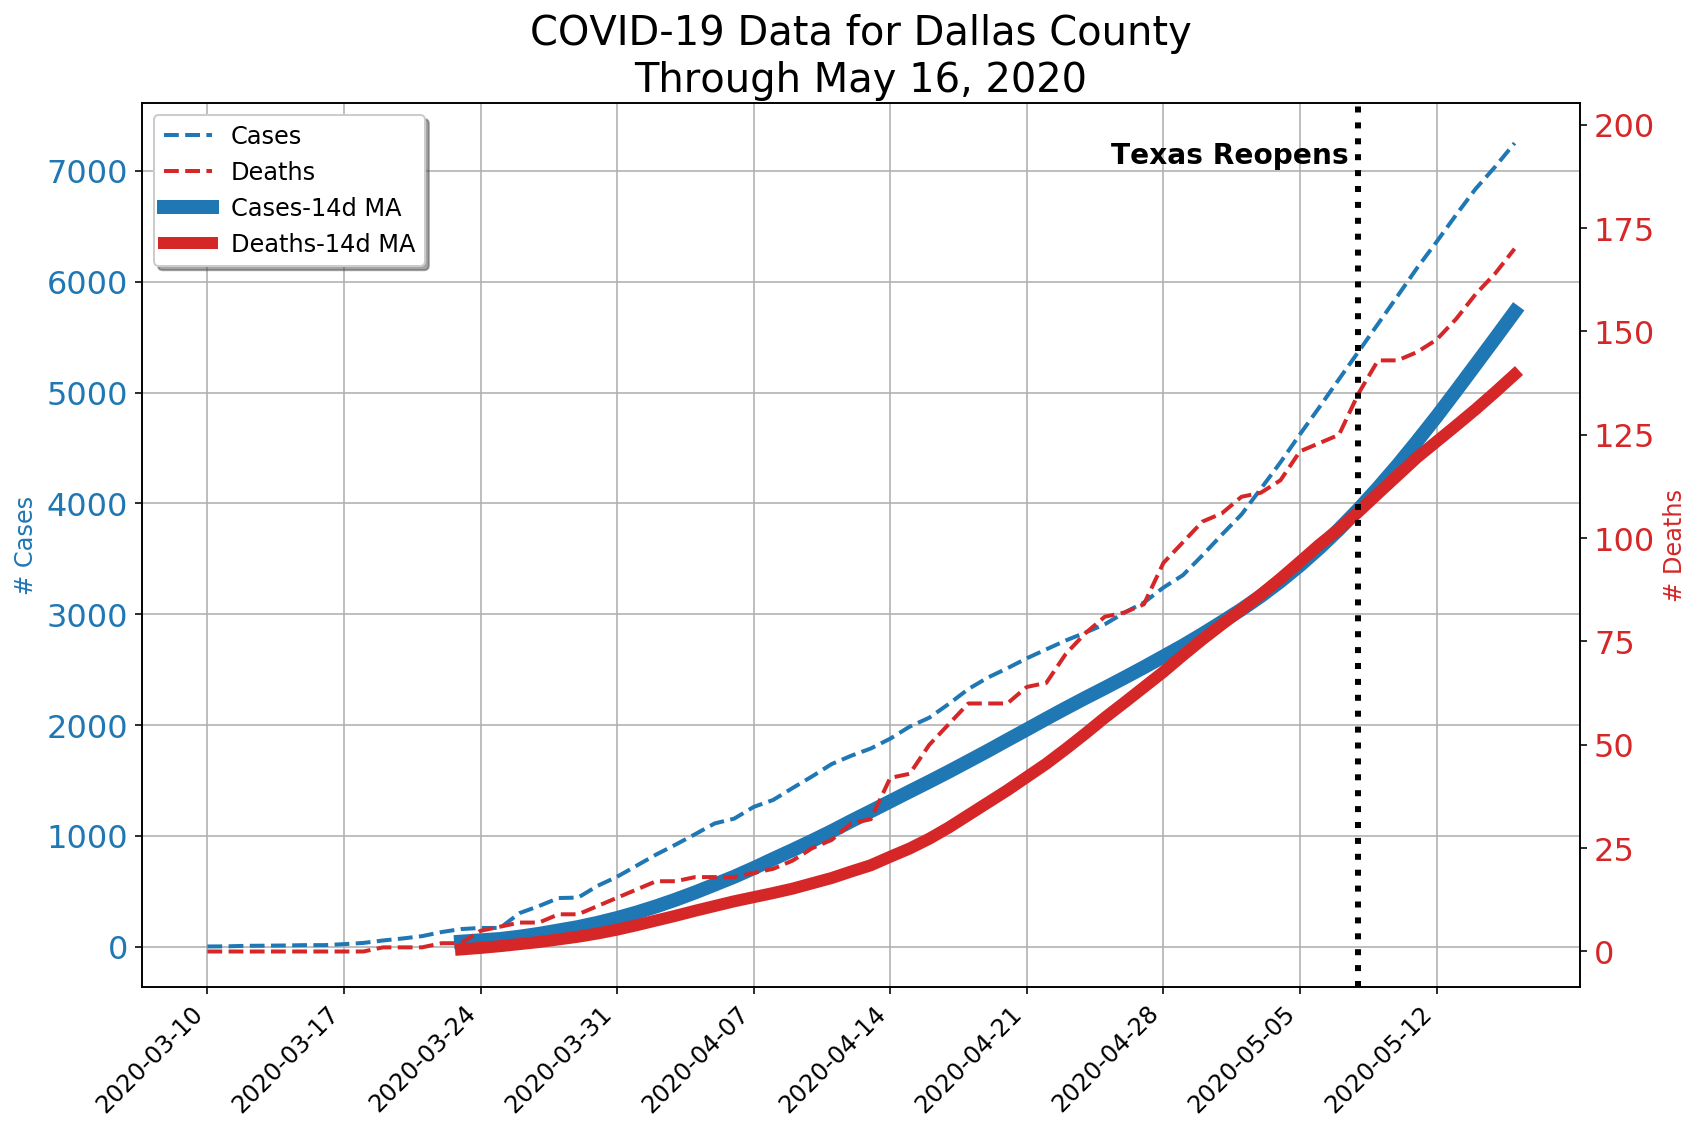

In [11]:
### plot the graph
fig, ax1 = plt.subplots(figsize=[12,8])

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'sans'})

## primary y axis - # Cases
color1 = 'tab:blue'
ax1.set_ylabel('# Cases', color=color1)
lc, = ax1.plot(df_txdfw_pivot['cases'], linewidth=2, color=color1, linestyle='--')
lcma, = ax1.plot(df_txdfw_pivot['cases_14dma'], linewidth = 7, color=color1, linestyle='-')
ax1.set_xticks(ax1.get_xticks()[::7])
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=16)
ax1.grid(True)

## secondary y axis - # Deaths
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('# Deaths', color=color2)
ld, = ax2.plot(df_txdfw_pivot['deaths'], linewidth=2, color=color2, linestyle='--')
ldma, = ax2.plot(df_txdfw_pivot['deaths_14dma'], color=color2, linewidth=6, linestyle='-')
ax2.set_xticks(ax2.get_xticks()[::7])
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=16)
y2_min, y2_max = ax2.get_ylim()
y2_max_new = y2_max * 1.15
ax2.set_ylim(bottom=y2_min, top=y2_max_new)

## x axis - display every 7 days

xmin, xmax = ax1.get_xlim()
latest_date_for_title = latest_day_dt.strftime("%b %d, %Y")

ax1.legend((lc, ld, lcma, ldma), ('Cases', 'Deaths', 'Cases-14d MA', 'Deaths-14d MA'), loc='upper left', shadow=True)
ax1.set_title(f"COVID-19 Data for Dallas County\nThrough {latest_date_for_title}", fontsize=20)

plt.axvline('2020-05-08', color='k', linewidth=3, linestyle=':')
#arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05 }
ax2.annotate('Texas Reopens', xy=('2020-05-08', y2_max_new), ha='right', xytext=(-5,-30), textcoords='offset points', fontsize=14, fontweight='bold')

fig.tight_layout()
plt.show()